Virtual Acoustics and Immersive Audio Workshop - CCRMA Stanford University  
25.07.25 - Orchisama Das, Gloria Dal Santo
  
### L05: Modeling Acoustics in Coupled Spaces

In this assignment we will 
- Analyize the EDC of a couple room space 
- Given a set of common slope parameters, synthesize the EDC and compare it with the one measured 

In [1]:
# --- Imports ---
import pickle
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from room_acoustics.analysis import compute_edc
from room_acoustics.synthesis import decay_kernel
from utils import filterbank

#### 1. Load the SRIR and plot the EDC 

The srirs are stored in `srirs_sampled.pkl` as a dictionary. You can use `srir_set.keys()` to list all the fields it contains.  
The dataset that the SRIRs were taken from can be found on [zotero](https://zenodo.org/records/13338346):

> Georg Götz, Sebastian J. Schlecht, and Ville Pulkki. Common-slope modeling of late reverberation. *IEEE/ACM Transactions on Audio, Speech, and Language Processing*, Vol. 31, pp. 3945–3957, September 2023. doi: [10.1109/TASLP.2023.3317572](https://doi.org/10.1109/TASLP.2023.3317572)

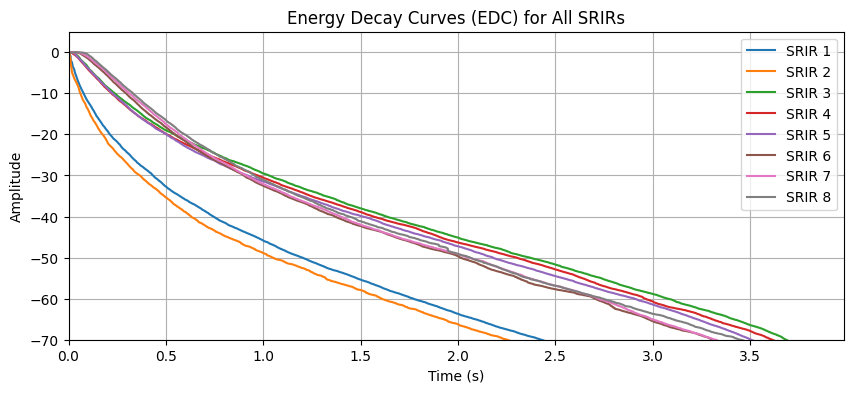

In [2]:
# --- Load the SRIRs and plot their EDC ---

output_filepath = Path('..') / 'data' / 'srirs_sampled.pkl'
with open(output_filepath, 'rb') as f:
    srir_set = pickle.load(f)

srirs = srir_set['srirs']
fs = srir_set['fs'].item()
n_srirs = srirs.shape[0]
ir_len = srirs.shape[1]
f_bands = [63, 125, 250, 500, 1000, 2000, 4000, 8000]

plt.figure(figsize=(10, 4))
for idx in range(n_srirs):
    rir = srirs[idx, :]
    edc_curve = compute_edc(rir)
    time = np.arange(len(edc_curve)) / fs
    plt.plot(time, edc_curve, label=f'SRIR {idx+1}')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(0, time[-1])
plt.ylim(-70, 5)
plt.grid(True)
plt.legend()
plt.title('Energy Decay Curves (EDC) for All SRIRs')
plt.show()

#### 2. Synthesize the EDC from the Common Slopes Parameters

- 2.1 Head to `room_acoustics.synthesis`, you will find a partially coded function `decay_kernel` which will generate an exponential envelope decaying at the specified reverberation time. 
- 2.2 Multiply the decay envelopes by their respective amplitudes
- 2.3 Plot the individual scaled slopes and the summed ones (i.e. the synthesized EDCs). 

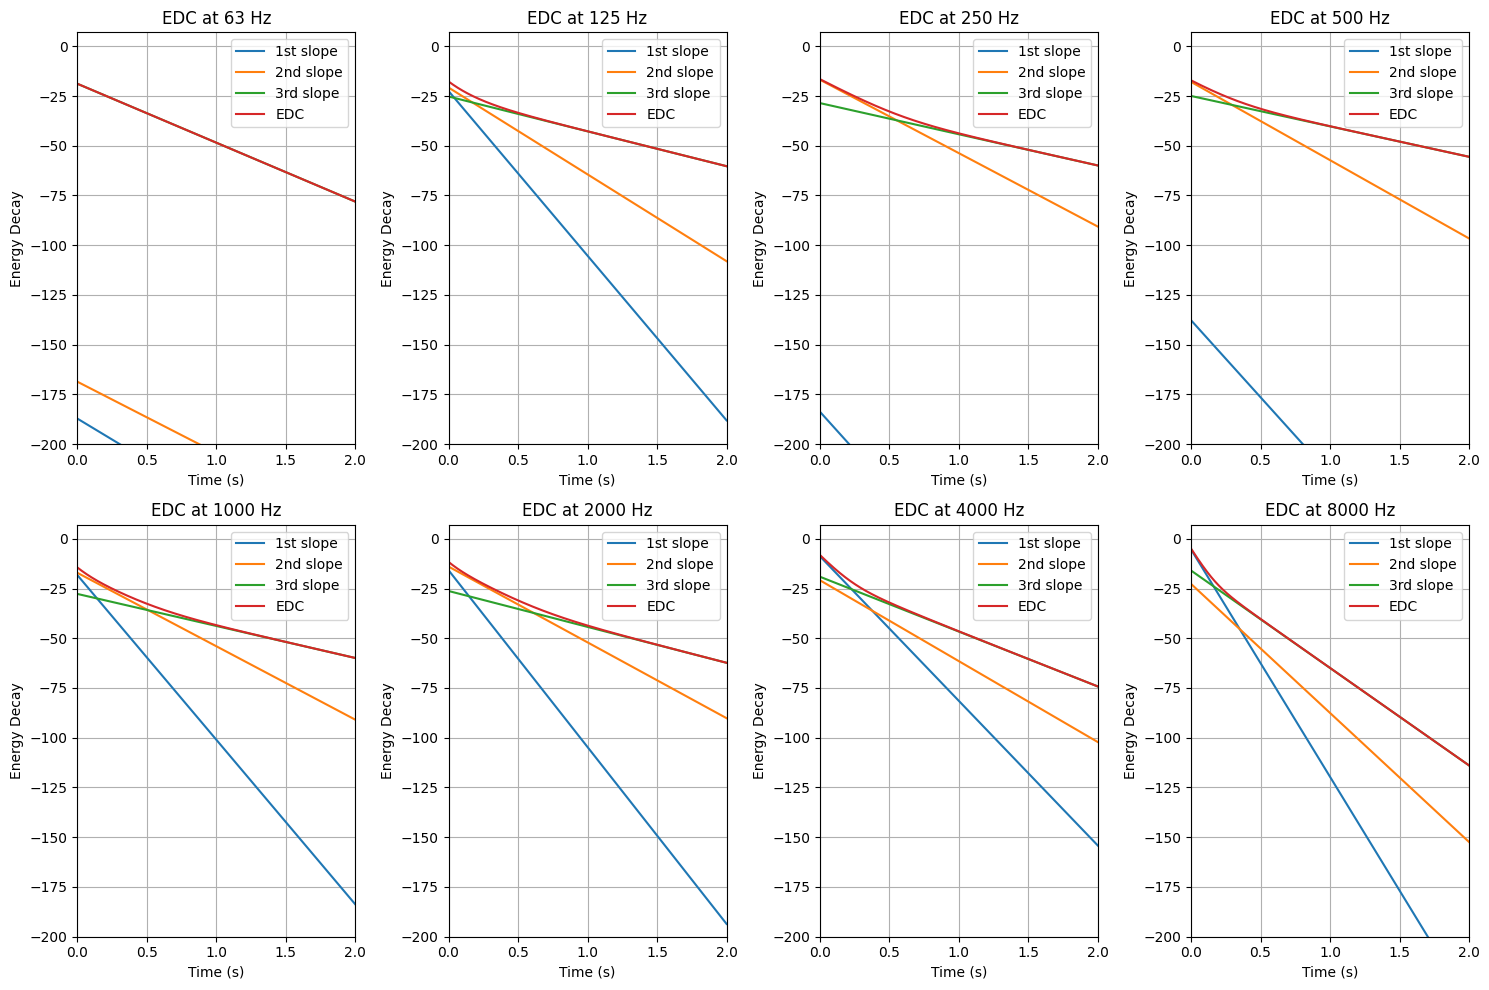

In [3]:
indx = 2

time_axis = np.arange(0, ir_len) / fs
envelope_decay = decay_kernel (np.squeeze(srir_set['common_decay_times']), 
                               time_axis, 
                               fs, 
                               normalize_envelope=False, 
                               add_noise=False)

# multiply the amplitudes of the SRIRs with the envelope decay to synthesize the EDC
# NOTE: the amplitudes are stored in the 'amplitudes' key of the srir_set dictionary. You have to access it via srir_set['amplitudes']
edc = np.reshape(srir_set['amplitudes'][:, :, indx], (len(f_bands), 1, -1))*envelope_decay

n_bands = len(f_bands)
plt.figure(figsize=(15, 10))
error = []
for i in range(n_bands):
    plt.subplot(2, 4, i+1)
    plt.plot(time_axis, 10*np.log10(edc[i, :, 0]), label='1st slope')
    plt.plot(time_axis, 10*np.log10(edc[i, :, 1]), label='2nd slope')
    plt.plot(time_axis, 10*np.log10(edc[i, :, 2]), label='3rd slope')
    plt.plot(time_axis, 10*np.log10(np.sum(edc[i, :, :], axis=-1)), label='EDC')
    plt.xlabel('Time (s)')
    plt.ylabel('Energy Decay')
    plt.legend()
    plt.title(f'EDC at {f_bands[i]} Hz')
    plt.ylim([-200, 7])
    plt.xlim([0, 2])
    plt.grid(True)

plt.tight_layout()
plt.show()

#### 3. Compare the EDC with the ground truth

- 3.1 Compute the EDC from the ground truth (GT) SRIR (accessable at `srir_set['srirs']`)
- 3.2 Plot the GT EDC and the synthesized ones after normalizing them so that they start at 0 dB at time 0

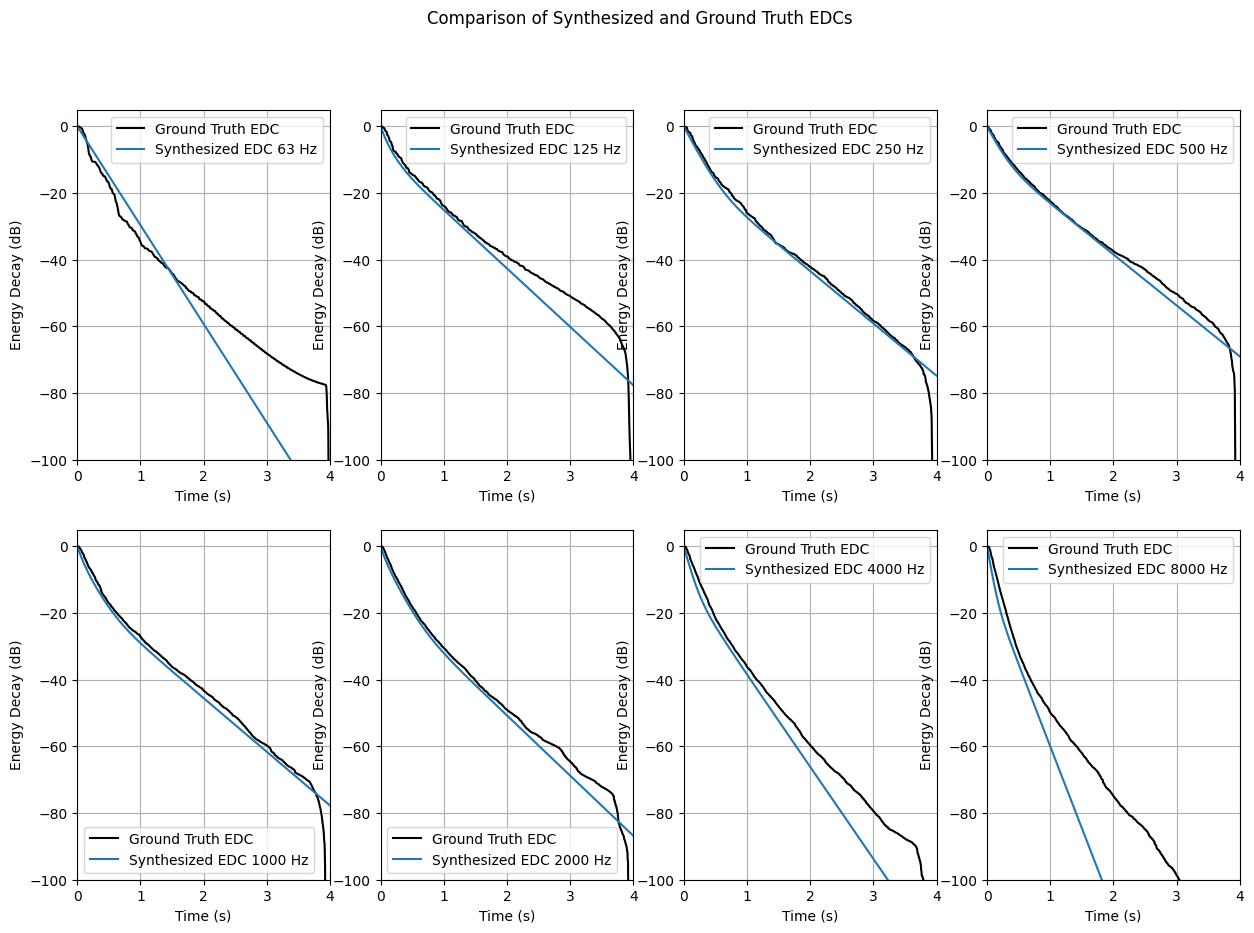

In [4]:
# --- Compare the EDC with the ground truth ---

# Select the SRIRs to compare (you have 8 SRIRs in total, access to one of them is given by `srirs[indx]`)
i_srir = srirs[indx]
# Filter the SRIR with a filterbank
srir_fb, center_freqs = filterbank(
    np.squeeze(i_srir),
    n_fractions=1, 
    f_min=f_bands[0],
    f_max=f_bands[-1],
    sample_rate=fs,
    filter_type='sos'
)

# plot the EDCs of the SRIRs and the synthesized EDCs
plt.figure(figsize=(15, 10))
for i in range(n_bands):
    plt.subplot(2, 4, i+1)

    # compute the ground truth EDC for the SRIRs   
    gt_edc = compute_edc(srir_fb[i, :])
    time_axis_gt = np.arange(len(gt_edc)) / fs
    synth = np.sum(edc[i, :, :], axis=-1)

    # plot the ground truth EDC and the synthesized EDC (in dB)
    plt.plot(time_axis_gt, gt_edc, label='Ground Truth EDC', color='black')
    plt.plot(time_axis, 10*np.log10(synth / max(synth)), label=f'Synthesized EDC {f_bands[i]} Hz')

    plt.xlabel('Time (s)')
    plt.ylabel('Energy Decay (dB)')
    plt.xlim(0, time_axis[-1])
    plt.ylim(-100, 5)
    plt.grid(True)
    plt.legend()
plt.suptitle('Comparison of Synthesized and Ground Truth EDCs')
plt.show()